Разобраться с моделькой перевода как она устроена

запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта
- с вниманием
- без внимания

оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке)

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-07-31 06:08:28--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  4.90MB/s    in 2.9s    

2022-07-31 06:08:32 (4.90 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [3]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 71M
drwxr-xr-x 2 root root 4.0K Jul 31 06:08 .
drwxr-xr-x 1 root root 4.0K Jul 31 06:08 ..
-rw-r--r-- 1 root root 1.5K May  2 01:29 _about.txt
-rw-r--r-- 1 root root  71M May  2 01:29 rus.txt


In [5]:
path_to_file = "/content/rus-eng/rus.txt"

f = open(path_to_file)
for line in f:
    print(line)
    break

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)



In [6]:
#функция препроцессинга
def preprocess_sentence(w):
  #переводим предложение к нижнему регистру и удалем начальные и конечные пробелы
    w = w.lower().strip()

  # отделяем пробелом слово и следующую за ним пунктуацию
  # пример: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

  # все, кроме букв и знаков пунктуации, заменяем пробелом
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  
  #удаляем лишние пробелы в начале и конце
    w = w.strip()

  # создаем начало и конец последовательности
  # теперь модель знает, где начинать и заканчивать предсказания
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
preprocess_sentence("Welcome, John Doe.")

'<start> welcome , john doe . <end>'

In [8]:
# 1. Убираем акценты
# 2. Очищаем предложения
# 3. Возвращаем пары слов в формате [ENG, RUS]
def create_dataset(path, num_examples):
  #считываем строки файла
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #каждую строку разделяем на пробелы, берем первые 2 слова, препроцессим их и возвращаем пару
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [10]:
len(en), len(ru)

(444587, 444587)

In [11]:
def tokenize(lang):
    #токенизируем текст, отфильтровываем пробелы
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    #обновляем внутренний словарь на основе lang
    lang_tokenizer.fit_on_texts(lang)
    #преобразуем каждый элемент из lang в последовательность чисел
    tensor = lang_tokenizer.texts_to_sequences(lang)
    #преобразуем тензор в матрицу (кол-во тензоров * max-длина), 
    #при этом короткие последовательности заполняем нулями сзади, а длинные -- обрезаем сзади
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
    # создаем очищенные анг (выходные), русские (входные) пары
    targ_lang, inp_lang = create_dataset(path, num_examples)
    #применяем токенизацию к каждому элементы из пары
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

input_tensor, target_tensor

(array([[    1,  5674,    24, ...,     0,     0,     0],
        [    1,   198,     3, ...,     0,     0,     0],
        [    1,   298,     3, ...,     0,     0,     0],
        ...,
        [    1,    19, 20543, ...,     0,     0,     0],
        [    1,    19,     9, ...,     0,     0,     0],
        [    1,    19,    60, ...,     0,     0,     0]], dtype=int32),
 array([[  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        ...,
        [  1,  28, 377, ...,   0,   0,   0],
        [  1,  28, 113, ...,   2,   0,   0],
        [  1,  28, 113, ...,   0,   0,   0]], dtype=int32))

In [14]:
# Максимальная длина тензоров
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(11, 15)

In [15]:
# Создаем train и validation датасеты
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# размеры датасетов
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [16]:
input_tensor_train, target_tensor_train

(array([[    1,     6,    21, ...,     0,     0,     0],
        [    1,     7,  1794, ...,     0,     0,     0],
        [    1,     8,    36, ...,     0,     0,     0],
        ...,
        [    1,   601,    28, ...,     0,     0,     0],
        [    1, 11581,    38, ...,     0,     0,     0],
        [    1,     4,  6840, ...,     0,     0,     0]], dtype=int32),
 array([[   1,    5,   16, ...,    0,    0,    0],
        [   1,   20,  438, ...,    0,    0,    0],
        [   1,   10,   16, ...,    0,    0,    0],
        ...,
        [   1,  133,   10, ...,    0,    0,    0],
        [   1, 2830,   10, ...,    0,    0,    0],
        [   1,   13,  928, ...,    0,    0,    0]], dtype=int32))

In [17]:
# выведем токен и его индекс
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> том
21 ----> был
2716 ----> здоров
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
16 ----> was
1092 ----> healthy
3 ----> .
2 ----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

#количество эпох
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

#из каждого элемента (input_tensor_train, target_tensor_train) создаем тензор
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

#разбиваем датасет на батчи (по 64), удаляя последний неполный батч
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
example_input_batch[0], example_target_batch[0]

(64, 15) (64, 11)


(<tf.Tensor: shape=(15,), dtype=int32, numpy=
 array([   1,    4,   21,   20, 2554,    3,    2,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32)>,
 <tf.Tensor: shape=(11,), dtype=int32, numpy=array([  1,   4,  16,  42, 663,   3,   2,   0,   0,   0,   0], dtype=int32)>)

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
    #создаем тензор из нулей размера (батч, кол-во ячеек)
        return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализируем начальное скрытое состояние (из нулей)
sample_hidden = encoder.initialize_hidden_state()
# применяем энкодер к входному батчу и скрытому состоянию
sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [25]:
sample_hidden

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[ 0.00279345,  0.00079668,  0.00668983, ..., -0.01356391,
         0.00889848, -0.02278931],
       [ 0.00273515,  0.00081348,  0.00678694, ..., -0.01365709,
         0.00899598, -0.0227816 ],
       [ 0.00272552,  0.00081304,  0.00688304, ..., -0.01346131,
         0.00889345, -0.02304052],
       ...,
       [ 0.00268576,  0.00083349,  0.00695001, ..., -0.01364292,
         0.00900791, -0.02300631],
       [ 0.00269743,  0.00079857,  0.00704304, ..., -0.01360227,
         0.00887853, -0.02311119],
       [ 0.00280718,  0.00075258,  0.00694553, ..., -0.01353536,
         0.00888505, -0.02300744]], dtype=float32)>

In [26]:
# декодер без внимания
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # x shape после прохождения через эмбеддинг == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # отправляем в GRU входные данные и скрытое состояние (от энкодера)
        #выход GRU (batch_size, timesteps, units)
        #размер возвращаемого внутреннего состояния (batch_size, units)
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # x shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [27]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходу энкодера
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 7334]), TensorShape([64, 1024]))

In [30]:
decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 7334]), TensorShape([64, 1024]))

In [31]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#функция потерь
def loss_function(real, pred):
    #делаем инверсию значений сравнения каждого из real с нулем (возвращается true или false)
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    #применяем функцию ошибок к реальным данным и предсказанным
    loss_ = loss_object(real, pred)

    #приводим тензор mask к новому типу loss_.dtype
    mask = tf.cast(mask, dtype=loss_.dtype)

    #умножаем loss_ на mask
    loss_ *= mask

    # возвращаем среднее значениe всех элементов
    return tf.reduce_mean(loss_)

In [32]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [33]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    #перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:
        #получаем выход encoder
        enc_hidden = encoder(inp, enc_hidden)
        #помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
                 #берем список длины батч из индексов тега <start> (1)
                 #приписываем списку размерность 1
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        #Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
            #enc_output в decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            #считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
            #используем teacher forcing (приписываем списку размерность 1)
            #посылаем dec_input на вход декордера 
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [34]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения. находим ошибку за эпоху
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    #сохраняем чекпоинт
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6141
Epoch 1 Batch 100 Loss 2.0479
Epoch 1 Batch 200 Loss 1.6954
Epoch 1 Batch 300 Loss 1.4451
Epoch 1 Batch 400 Loss 1.5667
Epoch 1 Batch 500 Loss 1.3462
Epoch 1 Batch 600 Loss 1.2754
Epoch 1 Batch 700 Loss 1.2900
Epoch 1 Batch 800 Loss 1.1437
Epoch 1 Batch 900 Loss 0.9732
Epoch 1 Batch 1000 Loss 1.0135
Epoch 1 Batch 1100 Loss 0.9293
Epoch 1 Batch 1200 Loss 1.1014
Epoch 1 Loss 1.3759
Time taken for 1 epoch 71.23550653457642 sec

Epoch 2 Batch 0 Loss 0.8855
Epoch 2 Batch 100 Loss 0.7367
Epoch 2 Batch 200 Loss 0.7006
Epoch 2 Batch 300 Loss 0.7107
Epoch 2 Batch 400 Loss 0.6874
Epoch 2 Batch 500 Loss 0.8204
Epoch 2 Batch 600 Loss 0.5959
Epoch 2 Batch 700 Loss 0.6093
Epoch 2 Batch 800 Loss 0.6245
Epoch 2 Batch 900 Loss 0.5348
Epoch 2 Batch 1000 Loss 0.5608
Epoch 2 Batch 1100 Loss 0.6005
Epoch 2 Batch 1200 Loss 0.5529
Epoch 2 Loss 0.6682
Time taken for 1 epoch 58.229467153549194 sec

Epoch 3 Batch 0 Loss 0.3852
Epoch 3 Batch 100 Loss 0.3662
Epoch 3 Batch 200 Loss 0.29

In [35]:
def evaluate(sentence):
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #заполняем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    #инициализируем входной hidden из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_hidden = encoder(inputs, hidden)

    #инициализируем входной hidden декодера -- выходной hidden энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        #предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [36]:
#функция перевода
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [37]:
# загружаем последний checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
translate('Сегодня идет дождь.')

Input: <start> сегодня идет дождь . <end>
Predicted translation: it's raining today . <end> 


In [39]:
translate('Следуй за своим сердцем')

Input: <start> следуй за своим сердцем <end>
Predicted translation: follow your heart ? <end> 


In [40]:
translate('Завтра мы поедем на пляж и будем там плавать.')

Input: <start> завтра мы поедем на пляж и будем там плавать . <end>
Predicted translation: we'll meet us today . <end> 


In [41]:
translate('Мы пойдем сегодня вечером в кино?')

Input: <start> мы пойдем сегодня вечером в кино ? <end>
Predicted translation: will we go tonight ? <end> 


In [42]:
translate('Мы смотрим телевизор.')

Input: <start> мы смотрим телевизор . <end>
Predicted translation: we're watching tv . <end> 


In [44]:
translate('Я сейчас работаю.')

Input: <start> я сейчас работаю . <end>
Predicted translation: i'm working now . <end> 


In [45]:
translate('Сегодня светит солнце.')

Input: <start> сегодня светит солнце . <end>
Predicted translation: the sun rose again . <end> 


In [46]:
translate('Ребята играют в футбол.')

Input: <start> ребята играют в футбол . <end>
Predicted translation: a drink soccer . <end> 


In [47]:
translate('Я люблю кататься на лыжах.')

Input: <start> я люблю кататься на лыжах . <end>
Predicted translation: i like skiing . <end> 


In [48]:
translate('Мы любим ходить гулять, если на улице хорошая погода.')

Input: <start> мы любим ходить гулять , если на улице хорошая погода . <end>
Predicted translation: we like to watch tv . <end> 


Видно, что с короткими фразами перевод вполне справляется. С более наполненными контекстом фразами перевод работает плохо.

**Построим модель с вниманием**

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()

#получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)

        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        
        #применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
        #складываем полученные векторы, применяем к сумму тангенс (batch_size, max_length, units)
        #проводим результат через dense слой (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        # получаем вероятностное распределение
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # умножаем веса внимания умножаем на векторы значенй выход (batch_size, max_len, hidden size)
        context_vector = attention_weights * values
        
        #находим вдоль столбцов (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
#создаем слой внимания
attention_layer = BahdanauAttention(10)
#передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [53]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_len, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) --> output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [54]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


In [55]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [56]:
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        #получаем выходы encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        #помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
             # берем список длины батч из индексов тега <start>
             # приписываем списку размерность 1
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        #Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
            #помещаем enc_output, dec_input, dec_hidden в decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
            # используем teacher forcing (приписываем списку размерность 1)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [57]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения и считаем ошибку
        batch_loss = train_step_att(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    #сохраняем checkpoint
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6018
Epoch 1 Batch 100 Loss 2.0182
Epoch 1 Batch 200 Loss 1.7890
Epoch 1 Batch 300 Loss 1.6157
Epoch 1 Batch 400 Loss 1.6067
Epoch 1 Batch 500 Loss 1.6216
Epoch 1 Batch 600 Loss 1.6133
Epoch 1 Batch 700 Loss 1.5391
Epoch 1 Batch 800 Loss 1.5449
Epoch 1 Batch 900 Loss 1.5675
Epoch 1 Batch 1000 Loss 1.4248
Epoch 1 Batch 1100 Loss 1.4800
Epoch 1 Batch 1200 Loss 1.3708
Epoch 1 Loss 1.6296
Time taken for 1 epoch 113.333327293396 sec

Epoch 2 Batch 0 Loss 1.3482
Epoch 2 Batch 100 Loss 1.2335
Epoch 2 Batch 200 Loss 1.2332
Epoch 2 Batch 300 Loss 1.2337
Epoch 2 Batch 400 Loss 1.2393
Epoch 2 Batch 500 Loss 1.0701
Epoch 2 Batch 600 Loss 1.0985
Epoch 2 Batch 700 Loss 1.0463
Epoch 2 Batch 800 Loss 0.9983
Epoch 2 Batch 900 Loss 1.0026
Epoch 2 Batch 1000 Loss 0.8604
Epoch 2 Batch 1100 Loss 0.6887
Epoch 2 Batch 1200 Loss 0.8022
Epoch 2 Loss 1.0671
Time taken for 1 epoch 102.33343005180359 sec

Epoch 3 Batch 0 Loss 0.6314
Epoch 3 Batch 100 Loss 0.6672
Epoch 3 Batch 200 Loss 0.630

In [58]:
def evaluate_attention(sentence):
    #строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #дополняем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    #инициализируем входной hidden из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    #инициализируем входной hidden декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)  
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        #сохраняем веса внимания, чтобы позже визуализировать
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        #предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


In [59]:
# визуализация весов внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [60]:
def translate_attention(sentence):
    result, sentence, attention_plot = evaluate_attention(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [61]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> сегодня идет дождь . <end>
Predicted translation: it is raining today . <end> 


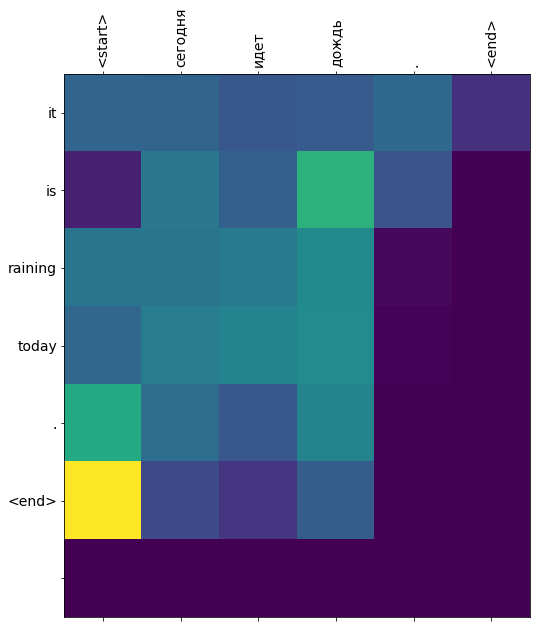

In [62]:
translate_attention('Сегодня идет дождь.')

Input: <start> следуй за своим сердцем <end>
Predicted translation: follow your heart . <end> 


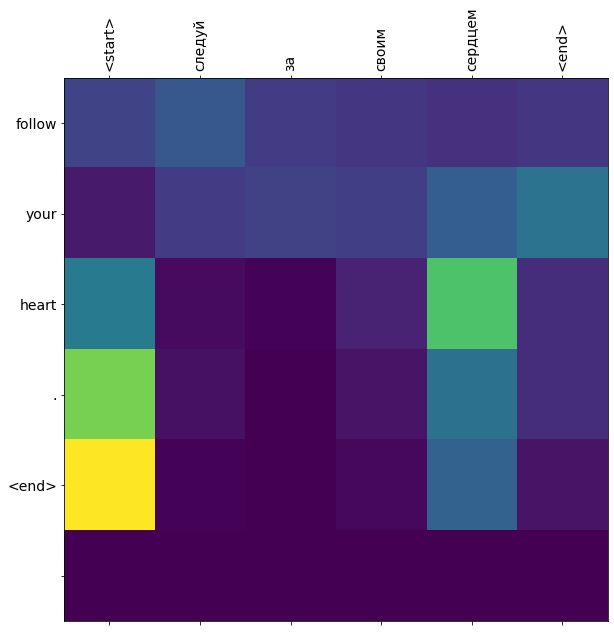

In [63]:
translate_attention('Следуй за своим сердцем')

Input: <start> завтра мы поедем на пляж и будем там плавать . <end>
Predicted translation: we'll go get the beach , too . <end> 


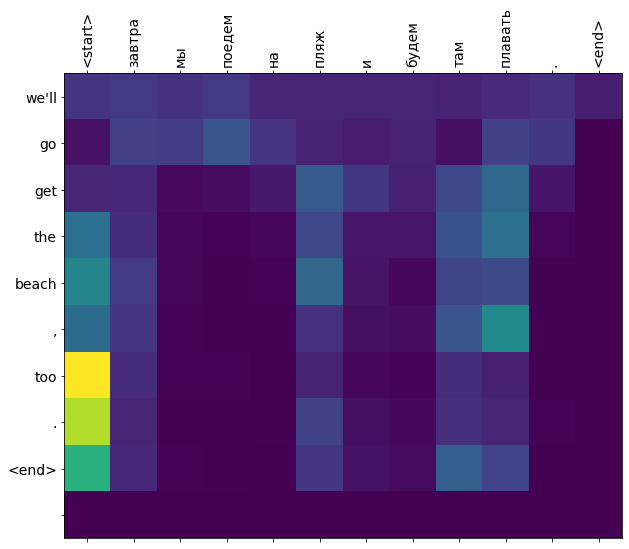

In [64]:
translate_attention('Завтра мы поедем на пляж и будем там плавать.')

Input: <start> мы пойдем сегодня вечером в кино ? <end>
Predicted translation: should we lied french ? <end> 


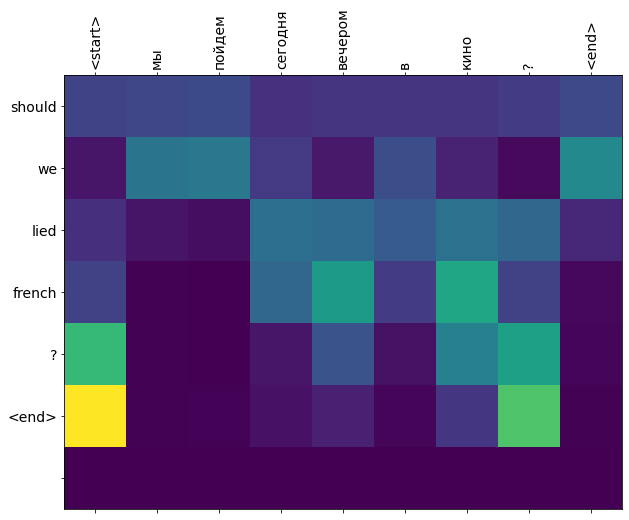

In [65]:
translate_attention('Мы пойдем сегодня вечером в кино?')

Input: <start> мы смотрим телевизор . <end>
Predicted translation: we're watching tv . <end> 


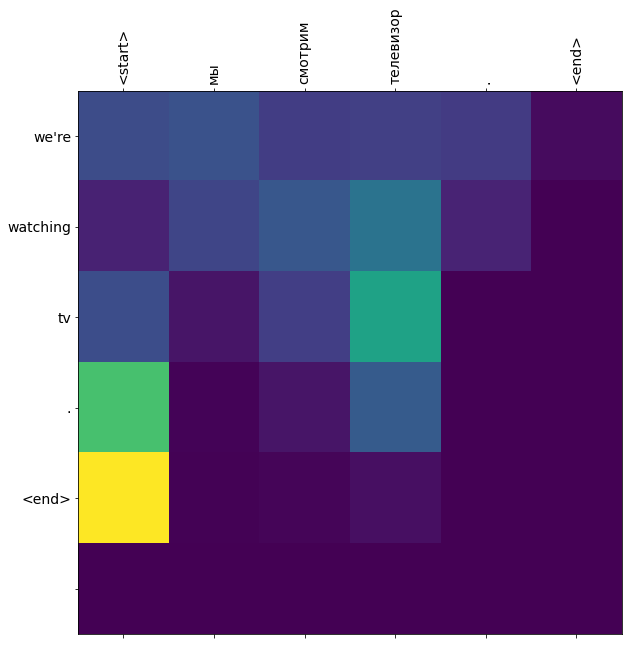

In [66]:
translate_attention('Мы смотрим телевизор.')

Input: <start> я сейчас работаю . <end>
Predicted translation: i'm working now . <end> 


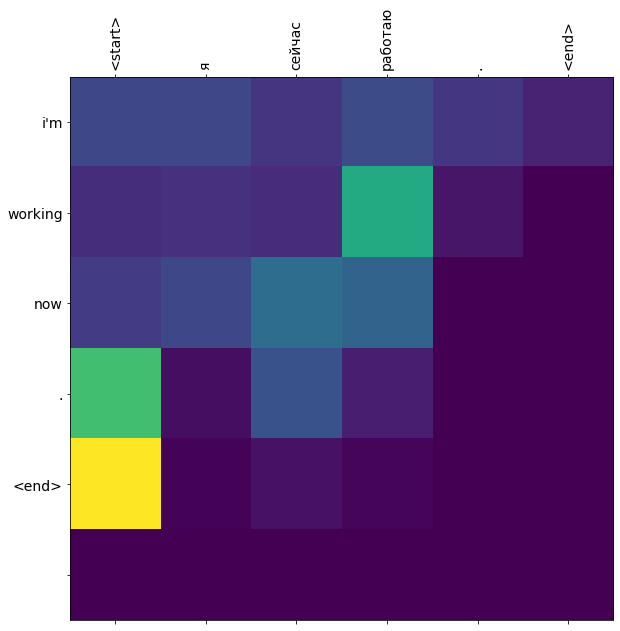

In [67]:
translate_attention('Я сейчас работаю.')

Input: <start> сегодня светит солнце . <end>
Predicted translation: the law is white . <end> 


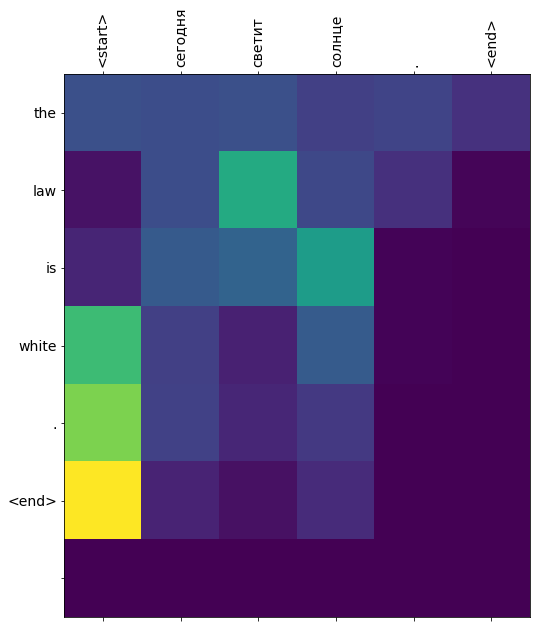

In [68]:
translate_attention('Сегодня светит солнце.')

Input: <start> ребята играют в футбол . <end>
Predicted translation: a cab is tense . <end> 


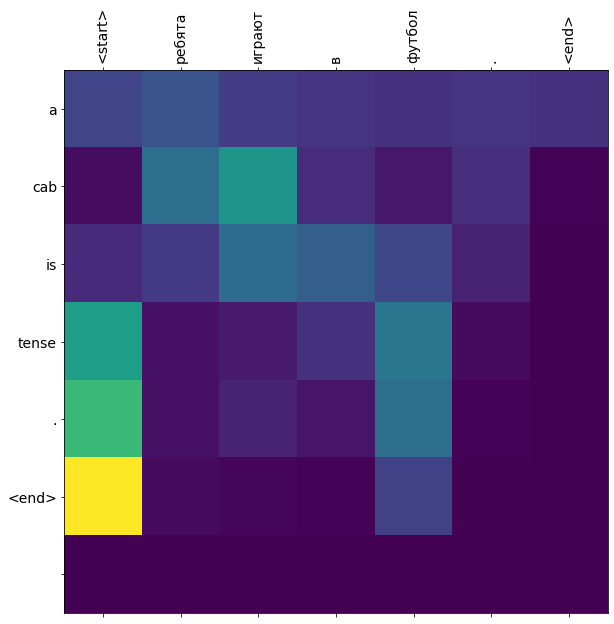

In [69]:
translate_attention('Ребята играют в футбол.')

Input: <start> я люблю кататься на лыжах . <end>
Predicted translation: i like skiing . <end> 


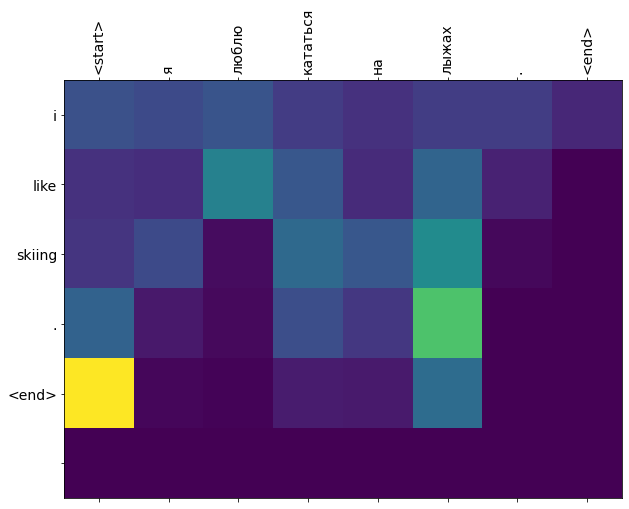

In [71]:
translate_attention('Я люблю кататься на лыжах.')

Input: <start> мы любим ходить гулять , если на улице хорошая погода . <end>
Predicted translation: we love if i still . <end> 


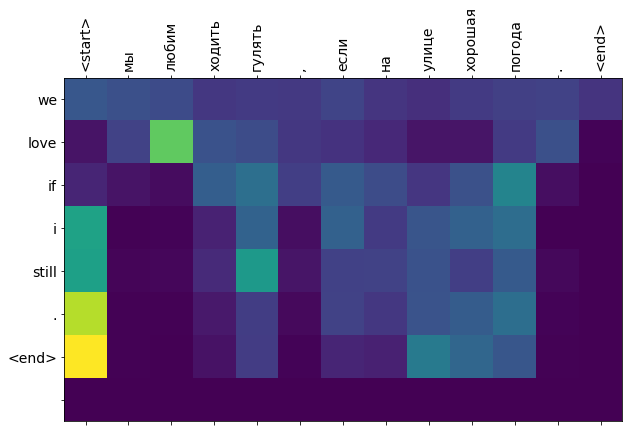

In [72]:
translate_attention('Мы любим ходить гулять, если на улице хорошая погода.')

Input: <start> модель плохого работает <end>
Predicted translation: a bad evening . <end> 


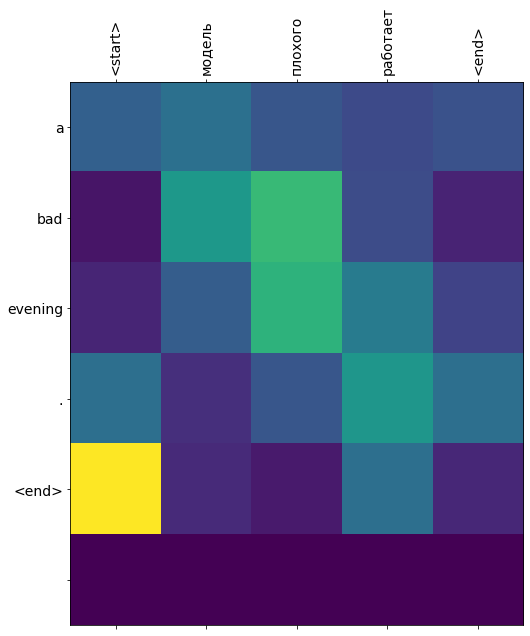

In [79]:
translate_attention('Модель плохого работает')

**Модель оказалась низкого качества. Особой разницы между моделью "без внимания" и "с вниманием" получить не удалось.**

Возможно необходимо использовать более внушительный объем токенов и как-то по-другому отслеживать качество и переобучение.